In [1]:
# load  the model
# load  the dataloaders
# see what the model is and how the model is being used

In [2]:
import sys
import os

# Add project root (one directory up from notebooks)
sys.path.append(os.path.abspath('..'))


In [15]:
import torch


# model related
from models.fff_model import resnet, MLP, brazy_encoder, brazy_decoder, cond_conv_encoder, cond_conv_decoder, FreeFormFlow, condFreeFormFlow, ImprovedCNN

# plotting related
from utils.plotting import  five_samples_same_model_during_training


# trainer
from training.trainer import train_model_mnist

# 
import tqdm
from typing import Literal


In [4]:
from dataclasses import dataclass
from typing import Literal, Union, Tuple, Any

# Configs for each architecture

@dataclass
class MLPConfig:
    pixelwidth: int
    fff_dim: int
    fff_layers: int

@dataclass
class ResNetConfig:
    pixelwidth: int
    fff_dim: int
    fff_layers: int
    fff_resnet_blocks: int

@dataclass
class BrazyConfig:
    fff_c_small: int
    fff_f1_dim: int
    fff_f2_dim: int
    third_convolutional_layer: bool
    fff_batchnorm: bool
    fff_dropout: float

# Main function

def get_encoder_and_decoder(
    fff_architecture: Literal["mlp", "resnet", "brazy"],
    config: Union[MLPConfig, ResNetConfig, BrazyConfig],
    device
) -> Tuple[Any, Any]:
    
    if fff_architecture == "mlp":
        assert isinstance(config, MLPConfig), "Config must be MLPConfig for 'mlp'"
        encoder = MLP(
            config.pixelwidth**2,
            config.fff_dim,
            config.pixelwidth**2,
            n_hidden_layers=config.fff_layers,
            device=device
        )
        decoder = MLP(
            config.pixelwidth**2,
            config.fff_dim,
            config.pixelwidth**2,
            n_hidden_layers=config.fff_layers,
            device=device
        )

    elif fff_architecture == "resnet":
        assert isinstance(config, ResNetConfig), "Config must be ResNetConfig for 'resnet'"
        encoder = resnet(
            input_dim=config.pixelwidth**2,
            hidden_dim=config.fff_dim,
            n_blocks=config.fff_resnet_blocks,
            output_dim=config.pixelwidth**2,
            hidden_layers=config.fff_layers
        )
        decoder = resnet(
            input_dim=config.pixelwidth**2,
            hidden_dim=config.fff_dim,
            n_blocks=config.fff_resnet_blocks,
            output_dim=config.pixelwidth**2,
            hidden_layers=config.fff_layers
        )

    elif fff_architecture == "brazy":
        assert isinstance(config, BrazyConfig), "Config must be BrazyConfig for 'brazy'"
        encoder = brazy_encoder(
            c_small=config.fff_c_small,
            f1_dim=config.fff_f1_dim,
            f2_dim=config.fff_f2_dim,
            third_conv=config.third_convolutional_layer,
            batchnorm=config.fff_batchnorm,
            p_dropout=config.fff_dropout
        )
        decoder = brazy_decoder(
            c_small=config.fff_c_small,
            f1_dim=config.fff_f1_dim,
            f2_dim=config.fff_f2_dim,
            third_conv=config.third_convolutional_layer,
            batchnorm=config.fff_batchnorm,
            p_dropout=config.fff_dropout
        )

    else:
        raise ValueError(f"Unknown architecture: {fff_architecture}")

    # Move both to device in one place
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    return encoder, decoder


In [5]:
device= 'cpu'#"cuda" if torch.cuda.is_available() else "cpu"
print(device)

pixelwidth = 28

cpu


In [6]:
# mlp_cfg = MLPConfig(pixelwidth=28, fff_dim=128, fff_layers=3)
# resnet_cfg = ResNetConfig(pixelwidth=28, fff_dim=128, fff_layers=2, fff_resnet_blocks=4)
brazy_cfg = BrazyConfig(
    fff_c_small = 32,
    fff_f1_dim = 256,
    fff_f2_dim = 512,
    third_convolutional_layer = True,
    fff_batchnorm = False,
    fff_dropout = 0.1
)

encoder, decoder = get_encoder_and_decoder("brazy", brazy_cfg, device="cuda")
# get the model
fours_fff = FreeFormFlow(encoder, decoder, device=device, data_dims=pixelwidth**2).to(device)
fours_fff

FreeFormFlow(
  (encoder): brazy_encoder(
    (dropout): Dropout(p=0.1, inplace=False)
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=6272, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=512, bias=True)
    (latent): Linear(in_features=512, out_features=784, bias=True)
    (batchnorm1): Identity()
    (batchnorm2): Identity()
  )
  (decoder): brazy_decoder(
    (dropout): Dropout(p=0.1, inplace=False)
    (fc2): Linear(in_features=784, out_features=512, bias=True)
    (fc1): Linear(in_features=512, out_features=256, bias=True)
    (fc_to_conv): Linear(in_features=256, out_features=6272, bias=True)
    (deconv3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (deconv2): ConvTranspose2d(64, 32, kernel_size=(3,

### Training some feature extractors

In [7]:
from data.dataloaders_related import  get_mnist_dataloaders
import torch.nn as nn

In [8]:
def train_feature_extractor(
    model_class,
    train_loader,
    device,
    learning_rate=0.001,
    epochs=5,
    extract_layer=20,
    print_every=100
):
    """
    Train a feature extractor model on the given dataloader.

    Args:
        model_class: The model class to instantiate (e.g., ImprovedCNN)
        train_loader: DataLoader for training data
        device: Device to train on ('cpu' or 'cuda')
        learning_rate: Learning rate for the optimizer
        epochs: Number of epochs to train
        extract_layer: Layer index for feature extraction
        print_every: Number of batches after which to print training progress

    Returns:
        Trained model (with model.is_trained = True)
    """

    # Initialize model, loss function, optimizer
    model = model_class().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs, extract_layer=extract_layer)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (batch_idx + 1) % print_every == 0:
                print(f"Epoch [{epoch + 1}/{epochs}], "
                      f"Step [{batch_idx + 1}/{len(train_loader)}], "
                      f"Loss: {running_loss / print_every:.4f}")
                running_loss = 0.0

    model.is_trained = True
    return model


In [9]:
# Hyperparameters
batch_size_feat_extractor = 64
learning_rate_feat_extractor= 0.001
epochs_feat_extractor = 5

# DataLoaders
train_loader, test_loader = get_mnist_dataloaders(batchsize=batch_size_feat_extractor, pixelwidth=28, digit=4)
zero_one_train_loader, zero_one_test_loader = get_mnist_dataloaders(batchsize=batch_size_feat_extractor, pixelwidth=28, digit=4, zero_one_range=True)

# Train both models
fid_feature_extractor = train_feature_extractor(
    ImprovedCNN, train_loader, device, learning_rate_feat_extractor, epochs_feat_extractor
)

zero_one_fid_feature_extractor = train_feature_extractor(
    ImprovedCNN, zero_one_train_loader, device, learning_rate_feat_extractor, epochs_feat_extractor
)


In [10]:
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs.to(device), extract_layer=20)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

# Evaluate the model on test data
test_model(fid_feature_extractor, test_loader)
test_model(zero_one_fid_feature_extractor, zero_one_test_loader)

Test Accuracy: 100.00%
Test Accuracy: 100.00%


### Training the FFF model

In [ ]:
# code to fix: fix the check_acfff_classification_quality thingy (for the time being I have set it to False.)

In [11]:
# train the model
fours_fff, fours_fff_metrics, fours_fff_snapshots = train_model_mnist(fours_fff,
                                                    model_name="fff",
                                                    digit=4,
                                                    pixelwidth=pixelwidth,
                                                    epochs=1000,
                                                    lr=0.0008,
                                                    batchsize=500,
                                                    beta_r=1.,
                                                    fid_feature_extractor=fid_feature_extractor,
                                                    ridge=None,
                                                    dequantization=None,
                                                    calculate_mmd=False,
                                                    calculate_fid=True,
                                                    weight_decay=1e-5,
                                                    lr_schedule=False,
                                                    calculate_is=False,
                                                    zero_one_range=False,
                                                    check_acfff_classification_quality=False)

In [13]:
import matplotlib.pyplot  as plt
from matplotlib.colors import Normalize
from matplotlib.ticker import LogLocator
import numpy as np

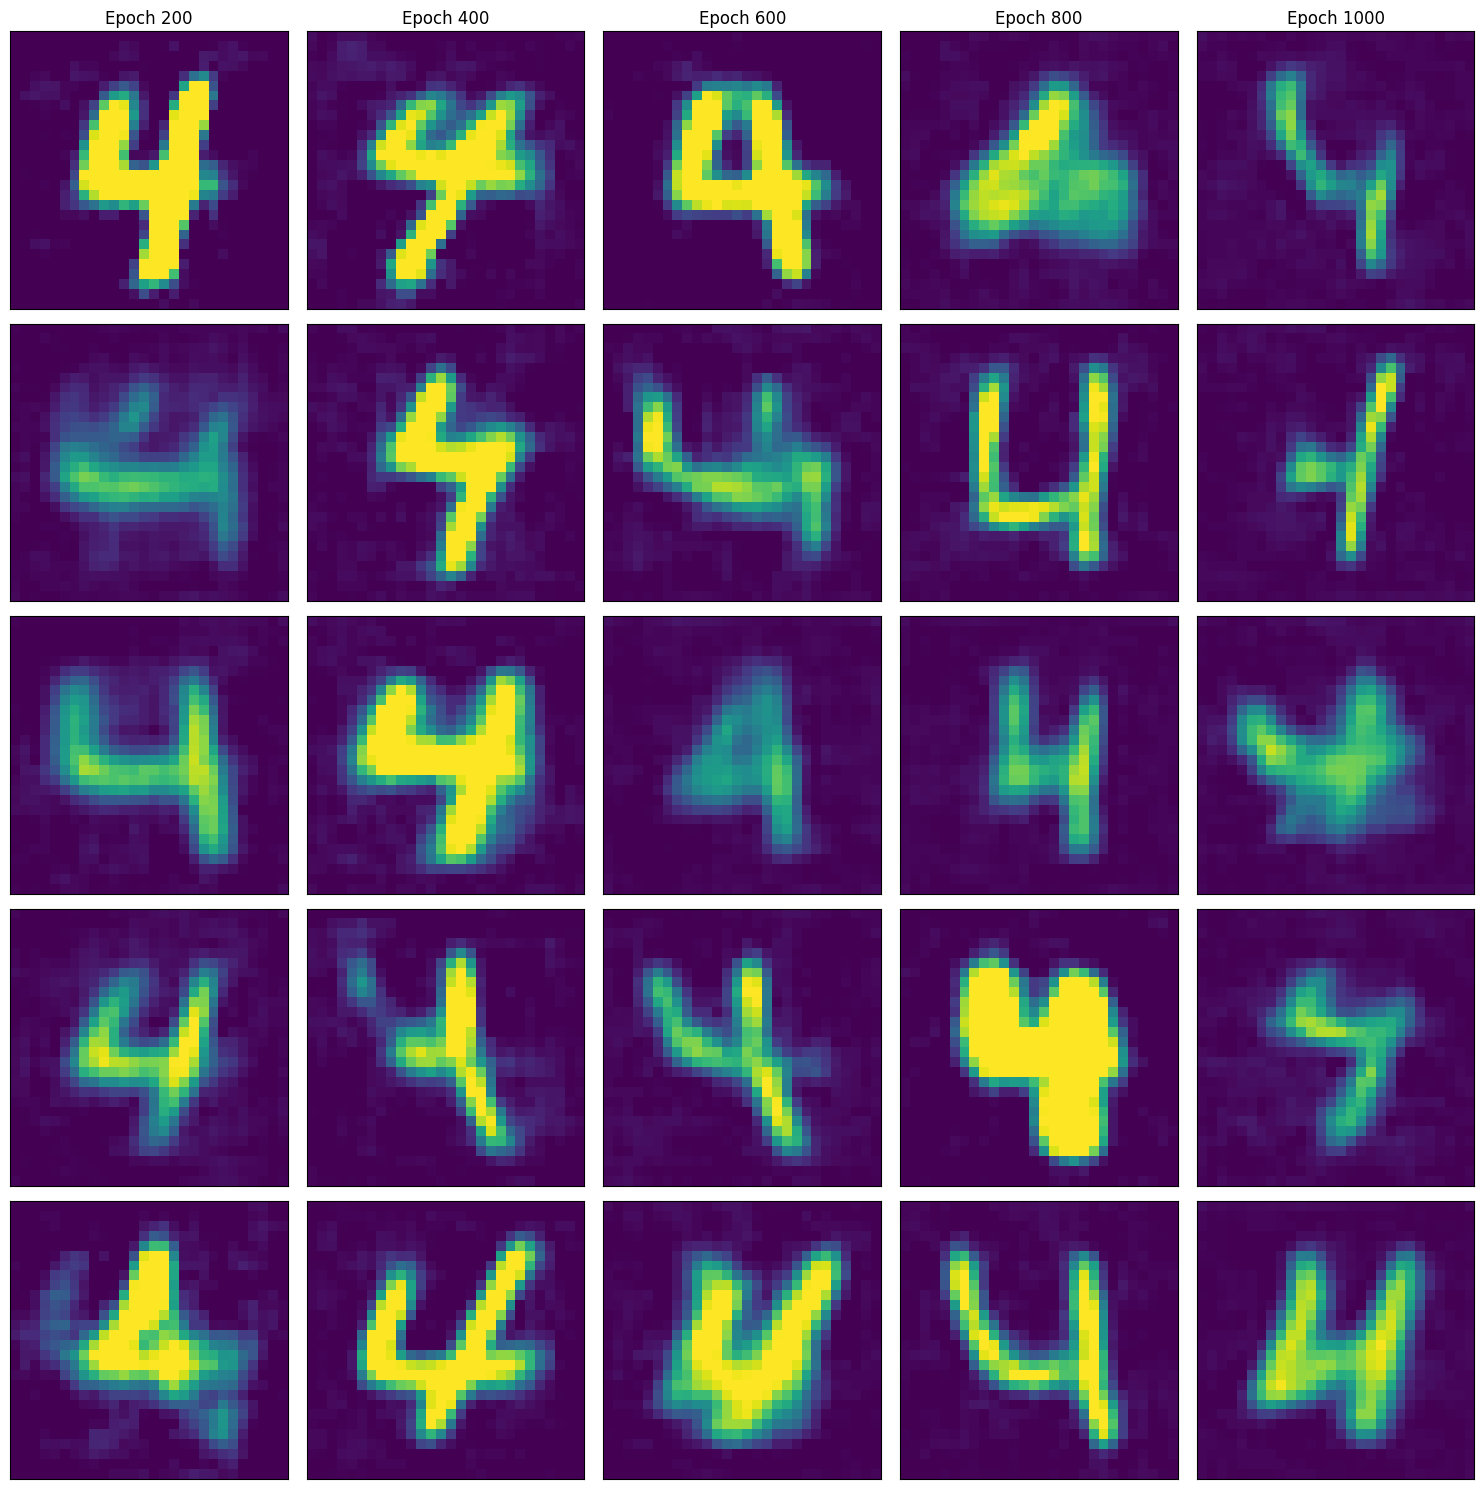

In [16]:
five_samples_same_model_during_training(fours_fff_snapshots, n_epochs=1000)#, save_path="best_fours_samples.png")

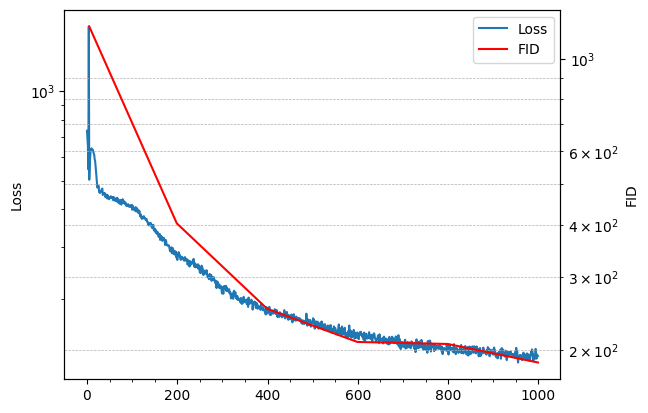

In [14]:
line1 = plt.plot(fours_fff_metrics["loss"], label="Loss")[0]
plt.yscale("log")
plt.ylabel("Loss")
ax = plt.twinx()
ax.set_yscale("log")
line2 = ax.plot(fours_fff_metrics["fid"][0], fours_fff_metrics["fid"][1], color="red", label="FID")[0]
ax.set_ylabel("FID")
plt.xlabel("Epochs")

lines = [line1,line2]
labels = [line.get_label() for line in lines]
plt.legend(lines, labels)

ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))  # Major ticks
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1, 10) * 0.1, numticks=10))  # Minor ticks

plt.grid(plt.grid(which='both', linestyle='--', linewidth=0.5))

ax.minorticks_on()